Imports:

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import tensorflow.keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import pydot
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv3D, Dropout,MaxPooling2D,AveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam

Load images:

In [3]:
folder_path = 'food/'
aim_folder_path = 'foodpreprocessed/'

img_width, img_height = 224, 224

# load all images into a list
file_list = sorted(os.listdir(folder_path))
images = []
names = []
i = 0
for img in file_list:
    if img == '.DS_Store':  # ignore stupid fookin mac file that wont go away
        continue
    thisname = img.split('.')[0]
    names.append(img)
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    np.save(aim_folder_path+thisname, img)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)

Load triplets:

In [4]:
df_triplets = pd.read_csv('train_triplets.txt', sep=" ", header=None)
print(df_triplets)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
59510   466  2952  2530
59511  2646  3580  2359
59512  3255  4844  4334
59513  2136  4619   161
59514  2509  2552  3406

[59515 rows x 3 columns]


Train-validation split:

In [5]:
df_triplets_train = pd.DataFrame(columns = [0, 1, 2])
df_triplets_val = pd.DataFrame(columns = [0, 1, 2])

N = 325
for idx, row in df_triplets.iterrows():
  if idx < N:  # first N rows go in train
    df_triplets_train = df_triplets_train.append(row)
  elif all(x not in df_triplets_train.values for x in [row[0], row[1], row[2]]):  # else if images not in train add to val
    df_triplets_val = df_triplets_val.append(row)
  elif all(x not in df_triplets_val.values for x in [row[0], row[1], row[2]]):  # else if images not in val add to train
    df_triplets_train = df_triplets_train.append(row)
  # else we discard triplet
  
df_triplets_train = df_triplets_train.reset_index(drop=True)
df_triplets_val = df_triplets_val.reset_index(drop=True)

print(df_triplets_train)
print(df_triplets_val)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
15887   450   219  4712
15888   236  1229  4090
15889   880  1818   621
15890   466  2952  2530
15891  2646  3580  2359

[15892 rows x 3 columns]
         0     1     2
0      647  4571  3011
1      683  2848  2039
2     4404  2384  2478
3     1019  4241  4114
4     4108  1020  1523
...    ...   ...   ...
5000  4020  2390  1285
5001  4990  4028  2647
5002  1716  4431  3398
5003  1550  1222  1140
5004  1940    38  2869

[5005 rows x 3 columns]


Swap every other element so that 0/1 labels are balanced:

In [13]:
for i, row in df_triplets_train.iterrows():
  if i % 2 == 1:
    temp = row[1]
    df_triplets_train.at[i,1] = row[2]
    df_triplets_train.at[i,2] = temp
print(df_triplets_train)

for i, row in df_triplets_val.iterrows():
  if i % 2 == 1:
    temp = row[1]
    df_triplets_val.at[i,1] = row[2]
    df_triplets_val.at[i,2] = temp
print(df_triplets_val)

          0     1     2
0      2461  3450  2678
1      2299  4987  2499
2      4663  1056  3029
3      4532  1297  1186
4      3454  3809  2204
...     ...   ...   ...
15887   450  4712   219
15888   236  1229  4090
15889   880   621  1818
15890   466  2952  2530
15891  2646  2359  3580

[15892 rows x 3 columns]
         0     1     2
0      647  4571  3011
1      683  2039  2848
2     4404  2384  2478
3     1019  4114  4241
4     4108  1020  1523
...    ...   ...   ...
5000  4020  2390  1285
5001  4990  2647  4028
5002  1716  4431  3398
5003  1550  1140  1222
5004  1940    38  2869

[5005 rows x 3 columns]


Create labels:

In [7]:
#y_train = np.empty((df_triplets_train.shape[0], 1))
#y_train[::2] = 1
#y_train[1::2] = 0
#print(y_train)

#y_val = np.empty((df_triplets_val.shape[0], 1))
#y_val[::2] = 1
#y_val[1::2] = 0
#print(y_val)

#df_triplets_train['3'] = y_train
#df_triplets_val['3'] = y_val

df_triplets_train = df_triplets_train.sample(frac=1).reset_index(drop=True)
df_triplets_val = df_triplets_val.sample(frac=1).reset_index(drop=True)

y_train = df_triplets_train[0]
y_val = df_triplets_val[0]

df_triplets_train.to_pickle("df_tiplets_train_random")
df_triplets_val.to_pickle("df_tiplets_val_random")
np.save("y_train_random",y_train)
np.save("y_val_random",y_val)

Transform triplets of image indexes --> triplets of images:

In [8]:
def imageLoader(files, y_values, batch_size):

    im0 = files[0]
    im1 = files[1]
    im2 = files[2]
    
    L = len(im0)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X1 = someMethodToLoadImages(im0[batch_start:limit])
            X2 = someMethodToLoadImages(im1[batch_start:limit])
            X3 = someMethodToLoadImages(im2[batch_start:limit])
            X = [X1,X2,X3]
            Y = y_values[batch_start:batch_end]
            #print(Y)
            Y = np.vstack(Y)
            #print(X1.shape)
            #print(Y.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
            
def someMethodToLoadImages(im0):
    train_0 = []
    aim_folder_path = 'foodpreprocessed/'

    for imID in im0:
        train_0.append(np.load(aim_folder_path+str(imID).zfill(5)+'.npy'))
      #  print(train_0[-1].shape)
    train_0 = np.vstack(train_0)
    
    return train_0

def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    #print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    
#    posneg_sum = pos_dist + neg_dist
#    # compute loss
#    pos_dist  = pos_dist/posneg_sum
#    neg_dist  = neg_dist/posneg_sum
#   
#    loss = tf.cond(y_pred == 0, lambda: pos_dist, lambda: neg_dist)

    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

Setup model for three CNNs:

C:\Users\Kioskar\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


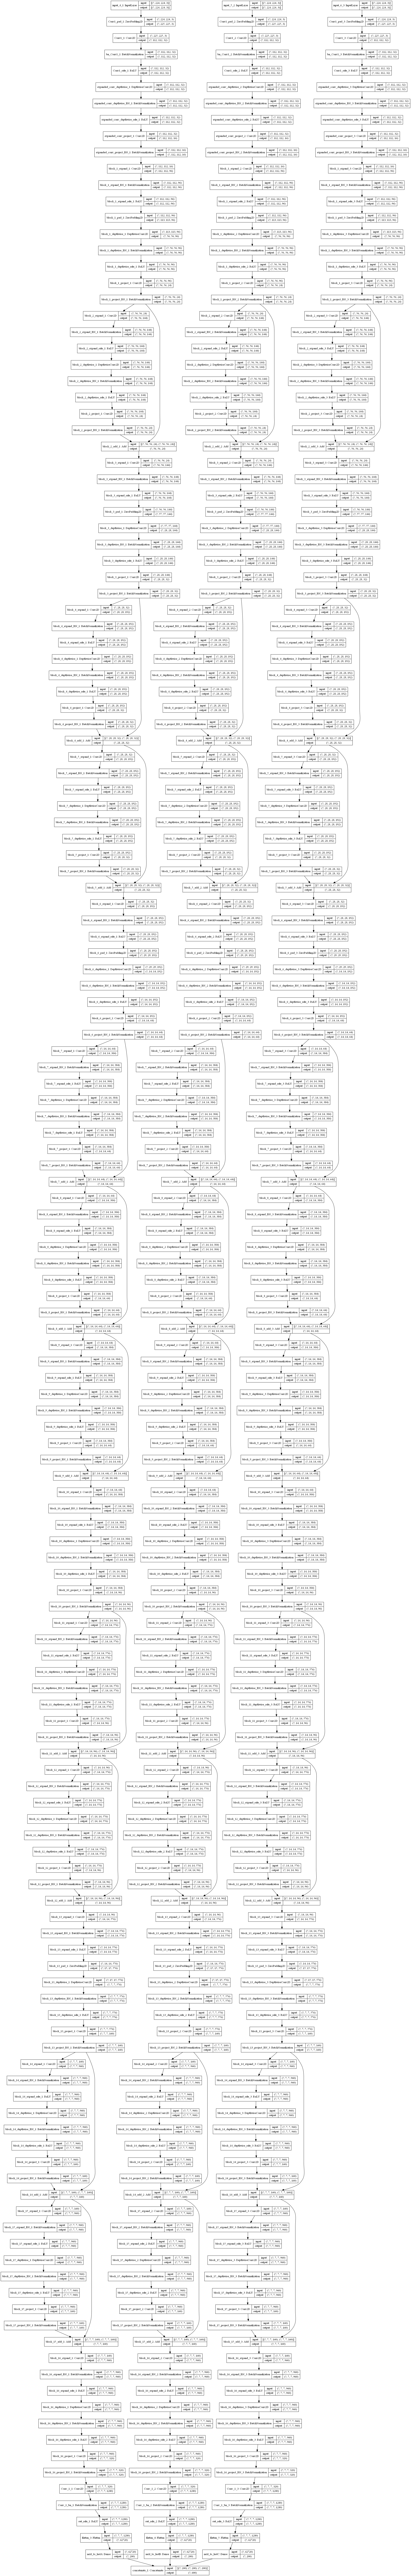

In [9]:
inputA = keras.Input(shape=(224, 224, 3))
inputB = keras.Input(shape=(224, 224, 3))
inputC = keras.Input(shape=(224, 224, 3))

base_modelA = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputA)
base_modelB = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputB)
base_modelC = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputC)
n = 5/6*len(base_modelA.layers)

i=0
for layer in base_modelA.layers:
  layer.trainable = False
  layer._name = layer._name + str("_1")
  i = i + 1 
  if i > n : 
        layer.trainable = True
i=0
for layer in base_modelB.layers:
  layer.trainable = False
  layer._name = layer._name + str("_2")
  i = i + 1
  if i > n : 
        layer.trainable = True
i=0
for layer in base_modelC.layers:
  layer.trainable = False
  layer._name = layer._name + str("_3")
  i = i + 1
  if i > n : 
        layer.trainable = True

num_classes = 200
xA = Flatten()(base_modelA.output)
xB = Flatten()(base_modelB.output)
xC = Flatten()(base_modelC.output)
xA = Dense(num_classes, activation='softmax',name='next_to_lastA')(xA)
xB = Dense(num_classes, activation='softmax',name='next_to_lastB')(xB)
xC = Dense(num_classes, activation='softmax',name='next_to_lastC')(xC)
out = layers.concatenate([xA,xB,xC],axis=-1)
#out = layers.Dense(10, activation='relu')(out)
#out = Dropout(rate = .2)(out)
#out = layers.Dense(10,activation='relu')(out)
#out = Dropout(rate = .2)(out)
#out = layers.Dense(1,activation='sigmoid',name='output')(out)

model = Model(inputs=[inputA,inputB,inputC], outputs=out)
opt = Adam(learning_rate=0.00000000001)
model.compile(loss=triplet_loss, optimizer=opt)

dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

#for l in model.layers:
#    print(l.name, l.trainable)

Train model:

In [ ]:
df_triplets_train = pd.read_pickle("df_tiplets_train_random")
df_triplets_val = pd.read_pickle("df_tiplets_val_random")
#y_train = np.load('y_train_random.npy')
#y_val = np.load('y_val_random.npy')

batch_size = 8
spe = df_triplets_train.shape[0]//batch_size
vs = df_triplets_val.shape[0]//batch_size
my_training_batch_generator = imageLoader(df_triplets_train, y_train, batch_size)
my_validation_batch_generator = imageLoader(df_triplets_val, y_val, batch_size)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(my_training_batch_generator,validation_data=(my_validation_batch_generator), steps_per_epoch=spe, validation_steps=vs, epochs=1,verbose=1,callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1986 steps, validate for 625 steps
1985/1986 [============================>.] - ETA: 0s - loss: 0.4015

In [ ]:
model.save('taste-similarity2.h5')

In [ ]:
## Augment model
modelPredict = model

layer_name = 'next_to_lastA'
modelPredictA = Model(inputs=modelPredict.input, outputs=[modelPredict.get_layer(layer_name).output,modelPredict.get_layer('next_to_lastB').output,modelPredict.get_layer('next_to_lastC').output])

dot_img_file = 'model_predict.png'
plot_model(modelPredictA, to_file=dot_img_file, show_shapes=True)

df_triplets_test = pd.read_csv('test_triplets.txt', sep=" ", header=None)
predictions = []
predictions_values = []
#print(df_triplets_test)
col0 = df_triplets_test[0]
col1 = df_triplets_test[1]
col2 = df_triplets_test[2]

for i in range(0,len(df_triplets_test[0])):
    #if i == 100:
    #    break
    im0 = col0[i]
    im1 = col1[i]
    im2 = col2[i]
    y_pred = model.predict([someMethodToLoadImages([im0]),someMethodToLoadImages([im1]),someMethodToLoadImages([im2])])
    y_pred = y_pred[0]
    total_length = len(y_pred)
    anchor = y_pred[0:int(total_length*1/3)]
    positive = y_pred[int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[int(total_length*2/3):int(total_length*3/3)] 
    #print(np.linalg.norm(anchor-positive))
    #print(np.linalg.norm(anchor-negative))
    if np.linalg.norm(anchor-positive)<np.linalg.norm(anchor-negative):
        predictions.append(1)
    else:
        predictions.append(0)


In [ ]:
print(predictions)
pd.DataFrame(predictions).to_csv("Answer.csv", header=None, index=None)